## Probability mass in high dimensions
#### By Yicheng Shen & Howard Jin

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import gamma
from scipy.integrate import quad, dblquad, tplquad

### Part 1 - Monte carlo

In this part, we implement the `mc_mass` function in order to perform Monte Carlo simulation on approximating the probability mass of multivariate normal distributions within `d`-dimensional shell. 

**Initialization**: After creating the zero mean vector and the identity covariance matrix (as assumed in the specification), we first generate `d`-dimensional multivariate normal random samples of size `n_sim` using the generator `default_rng()` and the `pdf()` method from `scipy.stats.multivariate_normal`. Then, according to the value of `breaks` parameter, we create the an `numpy` array of intervals, indicating the lower and upper bound of shells.

**Calculating Probability Mass**: The list `mass` is created to calculate the norm of each multivariate normal sample, and for each norm in `mass`, we first compare its value to see which shell interval it falls into, and then record its norm by adding it into the `shell_total_mass` array and incrementing the `shell_count` array by one on the corresponding shell index. Finally, the probability mass for each shell is obtained by dividing the `shell_count` array by total number of samples `n_sim`. For average radius of each shell, we simply return the midpoint of each break interval.

In [10]:
def mc_mass(d, n_sim=1000000, breaks=np.linspace(0,5,51), seed=1234):
    """
    This function uses monte carlo methods to approximate the probability mass of multivariate normal distributions within d-dimensional shells. \n User inputs could specify the number of dimensions, MC simulation and structure of shells. 
    """
    
    # Set up mean and covariance
    mean_vector = np.zeros(d)
    covariance_matrix = np.identity(d)
    # Set up the random generator with the seed
    rng = np.random.default_rng(seed = seed)
    # Generate MVN Samples
    MVN_Sample = rng.multivariate_normal(mean = mean_vector, cov = covariance_matrix, size = n_sim)
    
    
    # Set up the upper and lower points of each shell 
    shells = np.empty(shape=(len(breaks)-1, 2))
    for i in range(len(shells)):
        shells[i] = np.array([breaks[i], breaks[i+1]])
    
    # Calculate norm of each simulated MVN sample
    mass = [np.linalg.norm(sample) for sample in MVN_Sample]
    
    # Calcalate the prob mass
    shell_count = np.zeros(len(shells))
    shell_total_mass = np.zeros(len(shells))
    
    for one_mass in mass: 
        for i in range(len(shells)):
            if shells[i][0] <= one_mass < shells[i][1]: # Check which shell interval each sample falls into
                shell_count[i] += 1 # Increment count of each shell by one
                shell_total_mass[i] += one_mass # Increment prob mass of each shell by norm
                       
    probability_mass = shell_count/n_sim
    
    # Calcalate the average radius
    average_radius = np.zeros(len(shells)) 
    
    for i in range(len(average_radius)): 
        if shell_count[i] == 0:
            print("No simulated points visited shell", i+1, "in", d, "dimensional simulation. Recommend more simulations.")
            
    # Calcualte the average radius
    average_radius = np.empty(len(breaks)-1)
    for i in range(len(average_radius)):
        average_radius[i] = (breaks[i] + breaks[i+1]) / 2
    
    return (average_radius, probability_mass)

No simulated points visited shell 50 in 1 dimensional simulation. Recommend more simulations.


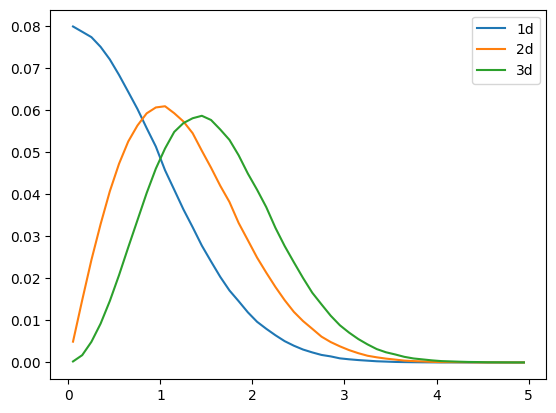

In [13]:
plt.cla()
plt.plot(*mc_mass(1), label="1d")
plt.plot(*mc_mass(2), label="2d")
plt.plot(*mc_mass(3), label="3d")
plt.legend()
plt.show()

No simulated points visited shell 1 in 9 dimensional simulation. Recommend more simulations.
No simulated points visited shell 2 in 9 dimensional simulation. Recommend more simulations.
No simulated points visited shell 3 in 9 dimensional simulation. Recommend more simulations.
No simulated points visited shell 1 in 16 dimensional simulation. Recommend more simulations.
No simulated points visited shell 2 in 16 dimensional simulation. Recommend more simulations.
No simulated points visited shell 3 in 16 dimensional simulation. Recommend more simulations.
No simulated points visited shell 4 in 16 dimensional simulation. Recommend more simulations.
No simulated points visited shell 5 in 16 dimensional simulation. Recommend more simulations.
No simulated points visited shell 6 in 16 dimensional simulation. Recommend more simulations.
No simulated points visited shell 7 in 16 dimensional simulation. Recommend more simulations.
No simulated points visited shell 8 in 16 dimensional simulatio

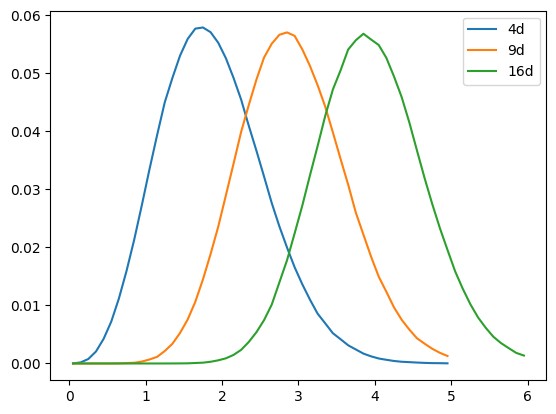

In [10]:
plt.cla()
plt.plot(*mc_mass(4), label="4d")
plt.plot(*mc_mass(9), label="9d")
plt.plot(*mc_mass(16, breaks=np.linspace(0,6,61)), label="16d")
plt.legend()
plt.show()

**Observation**: The plot above generates the probability masses of one million multivariate normal samples simulated from our `mc_mass` function versus their average radius on one, two, and three dimensions. The `1-d` result shows that the probability mass concentrates around the origin, which is intuitive and foreseeable. Nevertheless, as dimensionality increases, it is surprising to see that the mode of probability mass shifts to higher values, with heavier right tail and lighter left tail. This implies that as we continue to increase the dimensionality, the mode of probability mass of multivariate normal will move to higher value within the given `breaks` interval. To further investigate on whether the mode is proportional to the dimension d, we generate an additional plot on 4, 9, and 16 dimensions. The result shows that with $\sigma = 1$ across all dimensions with no correlation between different dimensions, the mode of probability mass occurs roughly around the radius of $\sqrt{d}$. In addition, as dimensionality increases, there tends to be more low-radius shell with no simulation points.

### Part 2 - Numerical integration

For this part, we implement the `ni_mass` function, which utilizes several numerical integration methods in `scipy` to calculate the probability mass of multivariate normal distributions within `d`-dimensional shell. Following the instruction of specification, we only consider the dimension $d \in (1,2,3)$.

**Initialization**: Similar to part 1, we first create the zero mean vector and the identity covariance matrix, which will be used in the following `pdf()` function. Besides, the arrays `probability_mass` and `shell_volume` are created to store the volumes of spheres and shells respectively.

**Calculating Probability Mass**: Depending on whether `d` is 1, 2, or 3, we will use the numerical integration methods `quad`, `dblquad`, and `tplquad`, respectively. The first argument is a lambda function which calculates the multivariate normal density given the mean and covariace. The upper and lower bound are chosen according to the formula of the volume of a d-dimensional sphere of radius r using cartesian coordinates: $$V_d(r) = \int_{-r}^r \int_{-\sqrt{r^2-x_1^2}}^\sqrt{r^2-x_1^2} \cdots \int_{-\sqrt{r^2-x_1^2-\ldots-x_{d-1}^2}}^\sqrt{r^2-x_1^2-\ldots-x_{d-1}^2}  1  dx_{d}\cdots dx_2  dx_1$$ It is also worth noting that for two parameters `epsabs` and `epsrel`, which represent the absolute and relative tolerance passed to integration, we change them to `1e-3` which is larger than default value. The reason is that slightly allowing more computational error will significantly save execution time. Our stretagy is first to calculate the volume of the sphere with the radius corresponding to the values in `breaks`, and store each sphere volume in `sphere_volume` array. Then, we obtain the probability mass for each shell by finding the difference in volume between consecutive spheres, storing the result in `probability_mass` array. For average radius of each shell, we simply return the midpoint of each break interval.

In [11]:
from scipy.stats import multivariate_normal
def ni_mass(d, breaks=np.linspace(0,5,51)):
    """
    This function uses SciPy’s numerical integration functions to “analytically” calculate the probability mass. \n User inputs should specify the number of dimensions. 
    """
    
    # Set up mean and covariance
    mean_vector = np.zeros(d)
    covariance_matrix = np.identity(d)
    
    probability_mass = np.zeros(len(breaks) - 1)
    sphere_volume = np.zeros(len(breaks))
    
    # support dim in 1,2,3 only 
    if d == 1: 
        for i in range(len(breaks)):
            sphere_volume[i] = quad(lambda x: multivariate_normal.pdf(x, mean=mean_vector, cov=covariance_matrix), 
                                       a = -breaks[i], b = breaks[i])[0]   # specify upper and lower bounds as formula suggests
    
            
    elif d == 2:
        for i in range(len(breaks)):
            sphere_volume[i] = dblquad(lambda x,y: multivariate_normal.pdf([x,y], mean=mean_vector, cov=covariance_matrix), 
                                       a = -breaks[i], b = breaks[i],
                                      gfun= lambda x: -np.sqrt(breaks[i]**2-x**2), hfun= lambda x: np.sqrt(breaks[i]**2-x**2),
                                     epsabs = 1e-3, epsrel = 1e-3)[0]  # allow more errors, save compuation. 
            
    elif d == 3: 
        for i in range(len(breaks)):
            sphere_volume[i] = tplquad(lambda x,y,z: multivariate_normal.pdf([x,y,z], mean=mean_vector, cov=covariance_matrix), 
                                       a = -breaks[i], b = breaks[i],
                                      gfun= lambda x: -np.sqrt(breaks[i]**2-x**2),hfun= lambda x: np.sqrt(breaks[i]**2-x**2),
                                      qfun= lambda x,y: -np.sqrt(breaks[i]**2-x**2-y**2), rfun=lambda x,y: np.sqrt(breaks[i]**2-x**2-y**2),
                                     epsabs = 1e-3, epsrel = 1e-3)[0]
            
    elif d not in [1,2,3]:
        print("Adjust the number of dim.")
            
    for i in range(len(breaks)-1):
        # Obtain prob mass by finding the difference in volume between consecutive spheres
        probability_mass[i] = sphere_volume[i+1] - sphere_volume[i] 
            
    # Calcualte the average radius
    average_radius = np.empty(len(breaks)-1)
    for i in range(len(average_radius)):
        average_radius[i] = (breaks[i] + breaks[i+1]) / 2
    
    return average_radius, probability_mass

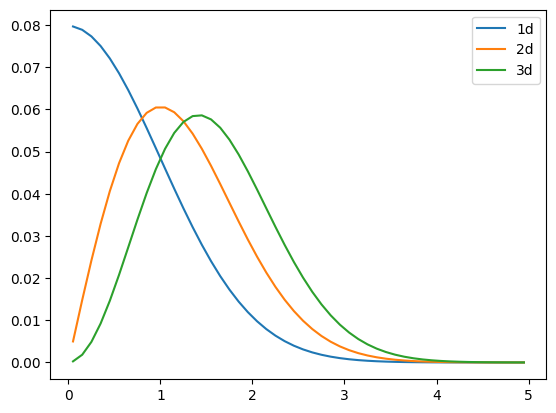

In [15]:
m1 = ni_mass(1)
m2 = ni_mass(2)
m3 = ni_mass(3)
 
plt.cla()
plt.plot(*m1, label="1d")
plt.plot(*m2, label="2d")
plt.plot(*m3, label="3d")
plt.legend()
plt.show()

**Observation**: The result using numerical integration is almost identical to that in part 1 using Monte Carlo simulation, with the mode of probability mass occurring nearly around the radius of $\sqrt{d}$. Since our function `ni_mass` only supports $d \in (1,2,3)$, we expect that under higher dimension, the mode of probability mass will hehave the same way as previous investigated.

### Part 3 - Summary and Conclusions

From the results from part 1 and 2, both Monte Carlo and numerical integration demonstrate that in the `1-d` case, the mode of probability mass of multivariate normal concentrates around the origin, and as dimensionality increases, the mode tends to move to regions with higher radius. Also, we expect that in general patterns, the mode of probability mass of multivariate normal with $\sigma = 1$ across all dimensions with no correlation between different dimensions occurs around the region with radius of $\sqrt{d}$.